In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches
import mplstereonet
import skimage.exposure
import harmonica as hm
import verde as vd

import micromag as mg

import time

# Read the real data

In [2]:
data_dir = pathlib.Path("..") / "data"
data = mg.load_qdm(data_dir / "Bz_uc0.mat")

# median = np.median(data.bz.values)
# data.bz.values -= median


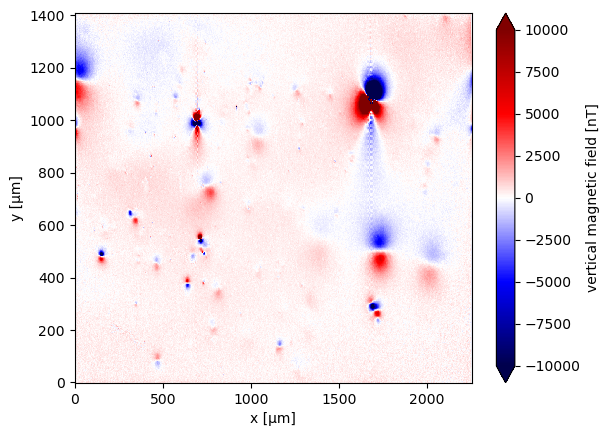

In [3]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=10000, vmin=-10000)

# Regional separation

In [4]:
data_table = vd.grid_to_table(data)

regional = vd.Trend(degree=3).fit((data_table.x, data_table.y), data.bz.values.ravel())

shape = data.bz.shape
regional_predicted=regional.predict((data_table.x, data_table.y))
regional_predicted = np.reshape(regional_predicted, shape)


data = data.assign(regional_predicted=(("y", "x"), regional_predicted))
data.regional_predicted.attrs = {"long_name": "vertical magnetic field", "units": "nT"}

# data.bz.values -= data.regional_predicted.values

data

<xarray.Dataset>
Dimensions:             (y: 600, x: 960)
Coordinates:
  * x                   (x) float64 0.0 2.35 4.7 ... 2.251e+03 2.254e+03
  * y                   (y) float64 0.0 2.35 4.7 ... 1.405e+03 1.408e+03
    z                   (y, x) float64 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0
Data variables:
    bz                  (y, x) float64 352.4 94.89 41.62 ... -4.196 -53.56 2.103
    regional_predicted  (y, x) float64 -158.8 -156.5 -154.1 ... 508.7 510.8
Attributes:
    file_name:  ../data/Bz_uc0.mat

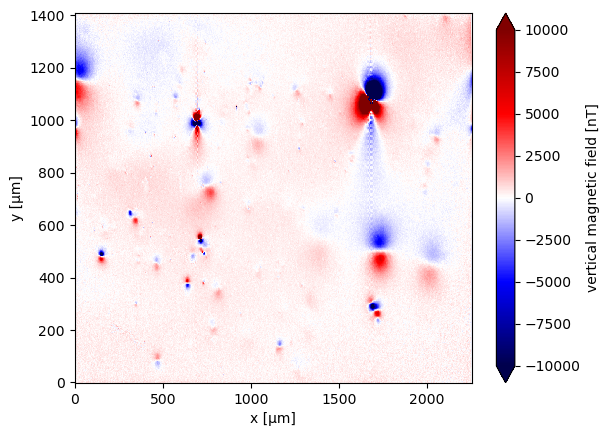

In [5]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=10000, vmin=-10000)

# Anomaly detection

First part of our method is an automatic way to detect and separate the signal of each dipole in the data. This is done in the following steps:

1. Upward continue the data to suppress high frequency noise
2. Calculate the total gradient amplitude (TGA) to concentrate the anomalies on top of the sources
3. Contrast stretch the TGA to highlight weaker sources
4. Run the Laplacian of Gaussian (LoG) method for blog detection to find the anomalies

In [6]:
# table = vd.grid_to_table(data)

## 1. Upward continue the data to suppress the high-frequency noise

In this step, we want to upward continue as little as possible to make sure we retain most of the signal.

In [7]:
height_difference = 5

# Have to assign the same points as the data because the Harmonica
# transforms give slightly different coordinates due to round-off.
# This is a bug and is being worked on.
data_up = (
    hm.upward_continuation(data.bz, height_difference)
    .assign_attrs(data.bz.attrs)
    .to_dataset(name="bz")
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
)

data_up.z.attrs = {"units": "µm"}

data_up

/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset>
Dimensions:  (y: 600, x: 960)
Coordinates:
  * x        (x) float64 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
  * y        (y) float64 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
    z        (y, x) float64 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 206.0 199.8 194.2 199.0 ... 282.8 266.5 236.6 204.7

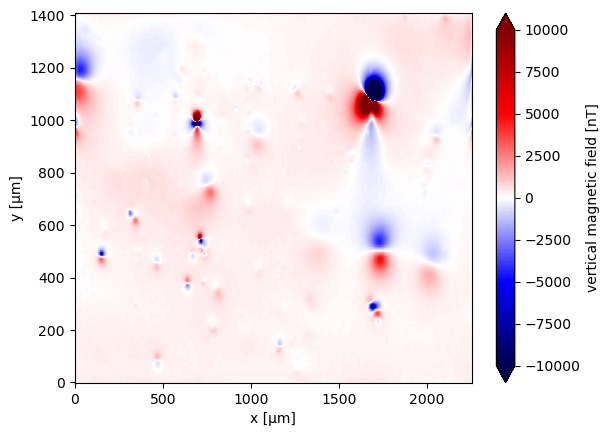

In [8]:
scale = 10000
data_up.bz.plot.pcolormesh(cmap="seismic", vmax=scale, vmin=-scale)

## 2. Calculate the TGA

We do this with finite difference derivatives to avoid amplifying noise.

In [9]:
data_up = data_up.assign(mg.data_gradients(data_up.bz))
data_up

/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset>
Dimensions:  (y: 600, x: 960)
Coordinates:
  * x        (x) float64 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
  * y        (y) float64 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
    z        (y, x) float64 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 206.0 199.8 194.2 199.0 ... 282.8 266.5 236.6 204.7
    tga      (y, x) float64 6.937 8.888 8.154 6.013 ... 24.89 24.13 23.33 21.11
    x_deriv  (y, x) float64 -2.652 -2.519 -0.1715 3.022 ... -9.835 -13.17 -13.58
    y_deriv  (y, x) float64 6.135 8.487 7.263 4.485 ... -17.43 -11.83 -1.096
    z_deriv  (y, x) float64 1.858 0.7877 3.704 -2.628 ... 16.04 13.48 15.2 16.12

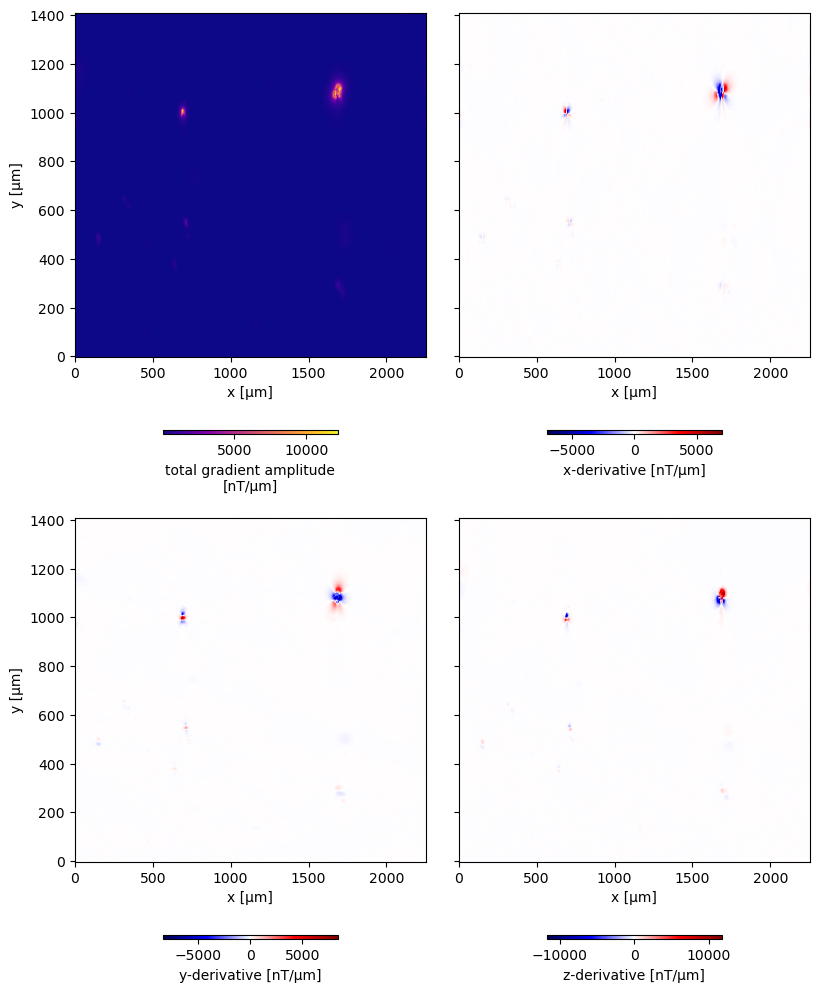

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10), sharey="row")
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.15, shrink=0.5)
for field, ax in zip(["tga", "x_deriv", "y_deriv", "z_deriv"], axes.ravel()):
    if field == "tga":
        cmap = "plasma"
        vmax=None
        vmin=None
    else:
        vmax= None# 500
        vmin= None#-500
        cmap="seismic"
    data_up[field].plot.pcolormesh(ax=ax, cmap=cmap, cbar_kwargs=cbar_kwargs, vmax=vmax, vmin=vmin)
for ax in axes.ravel():
    ax.set_aspect("auto")
    
axes[0,1].set_ylabel(None)
axes[1,1].set_ylabel(None)
plt.tight_layout(pad=0, h_pad=0, w_pad=2)

## 3. Stretch the contrast

Now we need to stretch the contrast of the TGA to make the anomalies easier to detect.

In [11]:
stretched = skimage.exposure.rescale_intensity(
    data_up.tga, 
    in_range=tuple(np.percentile(data_up.tga, (1, 99))),
)

data_up = data_up.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

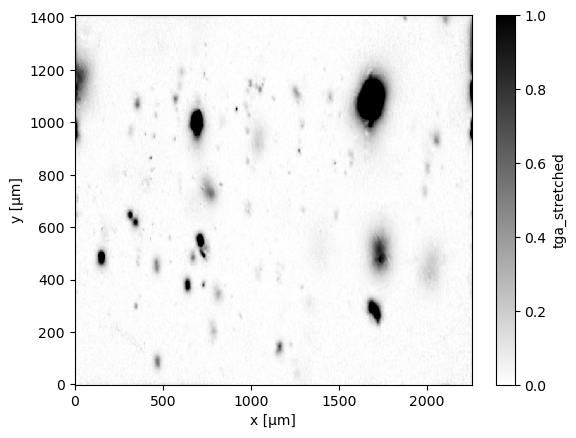

In [12]:
data_up.tga_stretched.plot.pcolormesh(cmap="gray_r")

## 4. Blob detection

To detect the bounding boxes of each anomaly, we use the LoG method in scikit-image. The code below calls it with some conveniences, like passing the range of anomaly sizes in physical units (µm) instead of number of pixels. It returns the bounding box of each anomaly (x_min, x_max, y_min, y_max) also in physical units.

In [13]:
start_detection_time = time.perf_counter()

windows = mg.detect_anomalies(
    data_up.tga_stretched, 
    size_range=[20, 200],
    size_increment=1.3,
    threshold=0.025,
    overlap=0.0,
    exclude_border=30,
    nsizes=10,
)

end_detection_time = time.perf_counter()

In [14]:
detection_time = end_detection_time-start_detection_time

print(f'{np.shape(windows)[0]} potential sources detected within {round(detection_time, 4)} seconds', )

100 potential sources detected within 1.5264 seconds


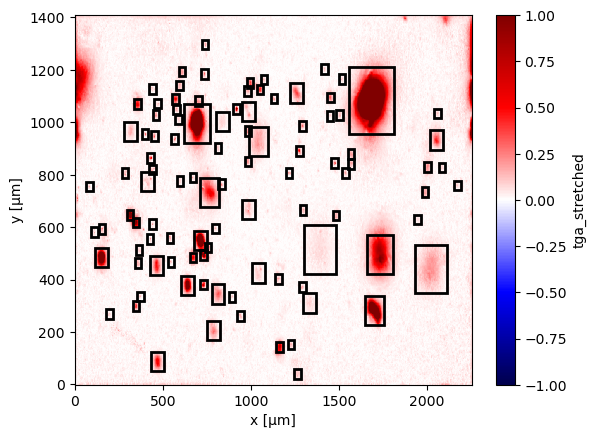

In [15]:
ax = plt.subplot(111)
scale = 1
data_up.tga_stretched.plot.pcolormesh(ax=ax, cmap="seismic", vmax=scale, vmin=-scale)
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)  
ax.set_aspect("auto")

Now that we know the bounding box of each anomaly, we can run the Euler deconvolution and moment inversion for each anomaly separately.

# Euler Deconvolution and Inversion (Standard method)

Run the Euler Deconvolution and the inversion on each window.

In [16]:
start_inversion_time = time.perf_counter()

positions = []
estimated_dipole_moments = []
estimated_stds = []
calculated_r2 = []
calculated_SNR = []
windows_filtered = []
base_levels = []
for window in windows:
    anomaly = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
    # anomaly = data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    # base_level = 0
    
    data_minus_background = anomaly.bz.values - base_level
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}
    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(
        anomaly.data_minus_background, position,
    )

    # Filter out solutions that don't meet quality criteria
    bad_euler = False#position[2] > 0
    poor_fit = False
#     poor_fit = r2 < 0.5
    bad_euler = position[2] > 0
    if bad_euler or poor_fit:
        continue
    print("R²: %s and SNR: %s"%(r2,SNR))  
    positions.append(position)  
    estimated_dipole_moments.append(moment)
    estimated_stds.append(mg.covariance_to_angle_std(moment, covariance))
    calculated_r2.append(r2)
    calculated_SNR.append(SNR)
    windows_filtered.append(window)
    base_levels.append(base_level)
positions = np.transpose(positions)


end_inversion_time = time.perf_counter()

R²: 0.8878576913878354 and SNR: 9.518730490743211
R²: 0.917351363699056 and SNR: 10.937779141369932
R²: 0.9946005039683814 and SNR: 23.059612094205395
R²: 0.7460754916587349 and SNR: 5.9772549247430735
R²: 0.9728510000308487 and SNR: 15.665320041566586
R²: 0.9972637031581711 and SNR: 25.690723677427002
R²: 0.9816835127392123 and SNR: 17.519415551075
R²: 0.9848937372877455 and SNR: 18.228055439427685
R²: 0.9991782555940185 and SNR: 31.41196258138453
R²: 0.7373843539031366 and SNR: 6.19558242818107
R²: 0.996075673389637 and SNR: 24.07048352494059
R²: 0.9603006258010941 and SNR: 14.128411903182084
R²: 0.9991423021526933 and SNR: 30.676100198449248
R²: 0.9970542831194269 and SNR: 25.86971781470576
R²: 0.9515262756130506 and SNR: 13.278426395217409
R²: 0.938429171309107 and SNR: 12.116199987881567
R²: 0.9949075769752441 and SNR: 23.08151531016862
R²: 0.9790322181547488 and SNR: 16.790183675715898
R²: 0.9679487807235353 and SNR: 15.023904818254179
R²: 0.966754444912002 and SNR: 14.9183209207

In [17]:
inversion_time = end_inversion_time-start_inversion_time
print(f"{positions.shape[1]} euler positions and dipole moments estimated within {round(inversion_time, 4)} seconds", )

75 euler positions and dipole moments estimated within 1.9574 seconds


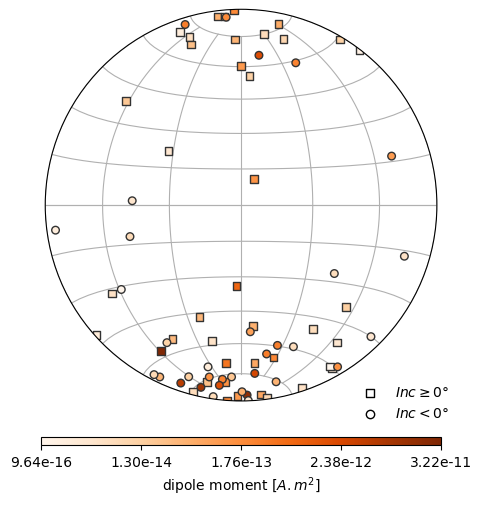

In [18]:
fig, ax = mplstereonet.subplots(1, 1, figsize=(4, 4), constrained_layout=True)
ax.grid()
estimated = mg.vector_to_angles(estimated_dipole_moments)
scatter_args = dict(
    vmin=np.log10(np.min(estimated[2])),
    vmax=np.log10(np.max(estimated[2])),
    cmap="Oranges",
    edgecolors="#333333",
    linewidths=1,
    s=30,
    zorder=2,
)
pos_inc = estimated[0] > 0
tmp = ax.scatter(
    *mplstereonet.line(estimated[0][pos_inc], estimated[1][pos_inc]),
    c=np.log10(estimated[2][pos_inc]),
    marker="s",
    **scatter_args,
)
tmp = ax.scatter(
    *mplstereonet.line(-estimated[0][~pos_inc], estimated[1][~pos_inc]),
    c=np.log10(estimated[2][~pos_inc]),
    marker="o",
    **scatter_args,
)

ticks=np.linspace( np.log10(np.min(estimated[2])),
                   np.log10(np.max(estimated[2])), 5)
tick_labels = []
for i in (ticks):
    tick_labels.append("{:.2e}".format(10**i))

    
clb = fig.colorbar(
    tmp, 
    cax=fig.add_axes([0, -0.1, 1, 0.02]), 
    orientation="horizontal", 
    label="dipole moment [$A.m^2$]",
    format="%.2e",
    ticks = ticks).set_ticklabels(tick_labels)

plt.scatter([],[], marker='s', color='white', edgecolors='k', label=r'$Inc \geq 0° $')
plt.scatter([],[], marker='o', color='white', edgecolors='k', label=r'$Inc < 0° $')

legend = plt.legend(bbox_to_anchor=(1.05, 9.0), frameon=1, framealpha=1.0)
frame = legend.get_frame()
frame.set_facecolor('w')
frame.set_edgecolor('w')

plt.show()

# Interactive Euler deconvolution

In [19]:
x_, y_ = np.meshgrid(data.x.values, data.y.values)
coordinates = ([x_, y_ , data.z.values])
# predicted_data = mg.dipole_bz(predicted_coordinates, positions, estimated_dipole_moments)

In [20]:
import warnings
import rich.progress

warnings.filterwarnings("ignore")

start_itr_euler_time = time.perf_counter()

x_concat = []
y_concat = []
z_concat = []
bz_concat = []
xc_concat = []
yc_concat = []
zc_concat = []
z_deriv_concat = []

estimated_dipole_moments_itr_euler = []

# fitting parameters
calculated_r2_itr_euler = []

data_copy = data.copy(deep=True)
data_up_copy = data_up.copy(deep=True)

################################# identify and remove all models with r2 >= 0.99 at once
euler_r2 = np.array(calculated_r2) > 1.01

for window in rich.progress.track(np.array(windows_filtered)[euler_r2], total = len(np.array(windows_filtered)[euler_r2])):
    anomaly = data_up_copy.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
    
    data_minus_background = anomaly.bz.values - base_level 
#     data_minus_background = data.sel(x=slice(*window[:2]), y=slice(*window[2:])).values
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}
    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)
    
    # store the results with the itr Euler (without interfering sources)
    estimated_dipole_moments_itr_euler.append(moment)

      ########
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue
#     print("R²: %s and SNR: %s | %s"%(r2,SNR,position[2]))  
    xx, yy = np.meshgrid(anomaly.x.values, anomaly.y.values)
    x_concat = np.append(x_concat, xx)
    y_concat = np.append(y_concat, yy)    
    z_concat = np.append(z_concat, anomaly.z.values)
    bz_concat = np.append(bz_concat, anomaly.bz.values)
    z_deriv_concat = np.append(z_deriv_concat, anomaly.z_deriv.values)
    xc_concat = np.append(xc_concat, position[0])
    yc_concat = np.append(yc_concat, position[1])
    zc_concat = np.append(zc_concat, position[2])  

# remove all signals 
position = np.array([xc_concat, yc_concat, zc_concat])
discard = mg.dipole_bz(coordinates, position, estimated_dipole_moments_itr_euler)
data_copy.bz.values -= discard



#################################
for window in rich.progress.track(np.array(windows_filtered)[~euler_r2], total = len(np.array(windows_filtered)[~euler_r2])):
    anomaly = data_up_copy.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
#     # using the real data to perform the dipole moment estimation
    # data_minus_background = data_copy['bz'].sel(x=slice(*window[:2]), y=slice(*window[2:])).values 
    data_minus_background = anomaly.bz.values - base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}
    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)
    
    # store the results with the itr Euler (without interfering sources)
    estimated_dipole_moments_itr_euler.append(moment)
    
    #########
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy.bz.values -= discard
    
#     print(discard.max())
    data_up_copy = (
                hm.upward_continuation(data_copy.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy.x, y=data_copy.y)
                .assign_coords(z=data_copy.z + height_difference)
                   )
    
    
    data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))
    
    
    ########
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue
    print("R²: %s and SNR: %s | %s"%(r2,SNR,position[2]))  
    xx, yy = np.meshgrid(anomaly.x.values, anomaly.y.values)
    x_concat = np.append(x_concat, xx)
    y_concat = np.append(y_concat, yy)    
    z_concat = np.append(z_concat, anomaly.z.values)
    bz_concat = np.append(bz_concat, anomaly.bz.values)
    z_deriv_concat = np.append(z_deriv_concat, anomaly.z_deriv.values)
    xc_concat = np.append(xc_concat, position[0])
    yc_concat = np.append(yc_concat, position[1])
    zc_concat = np.append(zc_concat, position[2])
    calculated_r2_itr_euler = np.append(calculated_r2_itr_euler, r2)


end_itr_euler_time = time.perf_counter()
warnings.resetwarnings()

Output()

Output()

R²: 0.8878576913878354 and SNR: 9.518730490743211 | -20.17646785323566

R²: 0.9173507443654606 and SNR: 10.937757151801419 | -5.930257402132998

R²: 0.9946008967062787 and SNR: 23.059581949840577 | -9.903736975349041

R²: 0.7461328535073708 and SNR: 5.977991059830085 | -14.64132409240846

R²: 0.9728488533545936 and SNR: 15.6650146166386 | -4.440947764626123

R²: 0.9972929817302767 and SNR: 25.72989803817 | -8.704571043832098

R²: 0.9816713775644512 and SNR: 17.51776977607489 | -9.955706021771439

R²: 0.9974598667208308 and SNR: 26.138447451874526 | -14.037490151660673

R²: 0.999163355831396 and SNR: 31.36999485050429 | -59.78435998115478

R²: 0.767471988715375 and SNR: 6.661145514221064 | -2.2283414035647207

R²: 0.9960653890550153 and SNR: 24.059235042141456 | -12.496684039071287

R²: 0.9635363099954228 and SNR: 14.499511932365511 | -2.3019125266235734

R²: 0.9991604750582279 and SNR: 30.769180940703706 | -13.54924829710034

R²: 0.9970572666620866 and SNR: 25.870862856054025 | -15.093692857979894

R²: 0.952404670875088 and SNR: 13.327498699016518 | -9.836986710678632

R²: 0.9388141842336056 and SNR: 12.144148081843971 | -40.881038319319075

R²: 0.9918864066835558 and SNR: 21.020229716465366 | -13.908063975661138

R²: 0.9790778224917673 and SNR: 16.798087237450215 | -15.50151844091231

R²: 0.9680142657119222 and SNR: 15.026224907081804 | -1.1530534269847146

R²: 0.9667804535774419 and SNR: 14.92263284957158 | -8.051352796976266

R²: 0.9449611586674155 and SNR: 12.612246684811954 | -1.337244623249202

R²: 0.9833589933522175 and SNR: 18.314873870469377 | -19.82694941637552

R²: 0.7369749487013506 and SNR: 5.853712942859859 | -0.4656837744379606

R²: 0.9639081810468426 and SNR: 14.495027251965366 | -16.098403014671995

R²: 0.970324621942039 and SNR: 15.556175714569447 | -23.778487171044944

R²: 0.9828712024095214 and SNR: 17.72067606079827 | -12.848822139963495

R²: 0.775676802574714 and SNR: 6.494672688629378 | -15.68547488894644

R²: 0.9579830816909263 and SNR: 13.788442256957964 | -4.515935953844762

R²: 0.9964860129282807 and SNR: 24.649222910966053 | -72.91959378936804

R²: 0.9317727605516117 and SNR: 11.688729805105131 | -6.507366614804518

R²: 0.7537107460115475 and SNR: 6.448419400916557 | -1.1588792031601303

R²: 0.9175660457849885 and SNR: 10.93884134037414 | -9.525648533853028

R²: 0.9145721349569106 and SNR: 10.69670839818426 | -11.570698607937176

R²: 0.9531502420997275 and SNR: 13.704181240453973 | -4.012357073252638

R²: 0.9284833505721303 and SNR: 11.457235595537501 | -18.903899446690943

R²: 0.9857540773991573 and SNR: 18.4632549021385 | -46.65388854160866

R²: 0.9650339852110326 and SNR: 14.708909982356865 | -1.6771881909888107

R²: 0.9948999964793916 and SNR: 22.92520867053571 | -12.263886219127176

R²: 0.7109246747666316 and SNR: 5.407656697558318 | -8.84729867763864

R²: 0.811399068179997 and SNR: 7.483523454638677 | -4.587205239681831

R²: 0.501159747841357 and SNR: 3.147085560549617 | -2.5253265515691674

R²: 0.5266611151768295 and SNR: 3.3388836290058825 | -0.5191692861081478

R²: 0.7908571322834969 and SNR: 7.060758263074824 | -3.5245369523777765

R²: 0.7499772656965692 and SNR: 6.116486979334777 | -13.015881830018056

R²: 0.8636378538986396 and SNR: 9.2158086953707 | -11.15783644160471

R²: 0.9306446116240871 and SNR: 11.612857972317261 | -4.227040054016337

R²: 0.5658093643366077 and SNR: 3.6700473578534694 | -1.3245655512213224

R²: 0.7848763742020171 and SNR: 6.791233285935892 | -8.013855341571622

R²: 0.9663448943390067 and SNR: 14.956542827407574 | -10.525235851142464

R²: 0.8950547185481809 and SNR: 9.90300847729021 | -6.153644139968674

R²: 0.68194345175756 and SNR: 5.040799778757902 | -1.1116289068383873

R²: 0.8790024969979646 and SNR: 9.175155227390796 | -5.688332728987526

R²: 0.9490813825378168 and SNR: 13.052871377874125 | -15.508504575229047

R²: 0.8542986178870748 and SNR: 8.367990529428607 | -13.824546406702263

R²: 0.6514045754141133 and SNR: 4.639123916004338 | -8.672448482598407

R²: 0.908439926359055 and SNR: 11.684354034867495 | -5.44489193499193

R²: 0.9662066130902971 and SNR: 14.80199047386699 | -22.124601882945516

R²: 0.4276786517820109 and SNR: 2.5206988420397707 | -0.06589778859130153

R²: 0.8135987606533348 and SNR: 7.299110112832401 | -4.753457663343569

R²: 0.6924963565110731 and SNR: 5.222066066245244 | 0.24966251290237337

R²: 0.9321048468981712 and SNR: 11.770302371308274 | -16.04505866157006

R²: 0.9792513688735303 and SNR: 17.074400789823514 | -13.860397676894138

R²: 0.44054193853829715 and SNR: 2.5694544635270233 | -6.483127320106121

R²: 0.8641107869194835 and SNR: 8.68565749341021 | 0.2508169183401078

R²: 0.5628528316223553 and SNR: 4.203586190261951 | -5.107068758491728

R²: 0.9007664814999032 and SNR: 10.535264031006939 | -32.91452217919924

R²: 0.926482499697243 and SNR: 11.721211977013917 | -2.518523777082857

R²: 0.4760535202814916 and SNR: 3.260079493896775 | -5.1501183969884945

R²: 0.4838973924161898 and SNR: 3.151710308640731 | -4.661232740090544

R²: 0.7381156809597631 and SNR: 5.81895967143089 | -5.341267332613031

R²: 0.6561518976217162 and SNR: 5.0308625093666945 | -1.3935973349778292

R²: 0.6393740874744833 and SNR: 4.43194480340385 | -6.447597551585715

R²: 0.88284737460284 and SNR: 9.466014003269075 | -7.599052159756232

R²: 0.9132495593574703 and SNR: 10.79404056698037 | -81.24160927463278

R²: 0.7451307943433787 and SNR: 6.090198722765478 | -10.57204001348649

In [21]:
itr_euler_time = end_itr_euler_time-start_itr_euler_time
print(f"Time for the iterative Euler solution and dipole moment estimation: {round(itr_euler_time, 4)} seconds", )

Time for the iterative Euler solution and dipole moment estimation: 15.5921 seconds


In [22]:
df = pd.DataFrame({'x':x_concat,
                   'y':y_concat,
                   'z':z_concat,
                  'bz':bz_concat,
                 'z_deriv':z_deriv_concat})

df.head()

,x,y,z,bz,z_deriv
0,1558.05,956.45,10.0,938.360552,-3.781992
1,1560.40,956.45,10.0,952.304002,-1.523999
2,1562.75,956.45,10.0,963.741913,0.269979
3,1565.10,956.45,10.0,974.210531,-3.107652
4,1567.45,956.45,10.0,978.968023,-0.464891


In [23]:
positions_itr = np.array([xc_concat, yc_concat, zc_concat])
# print(positions_itr)

## Directions and Dipole Moments comparions

### Iterative Euler (withou interf. sources)

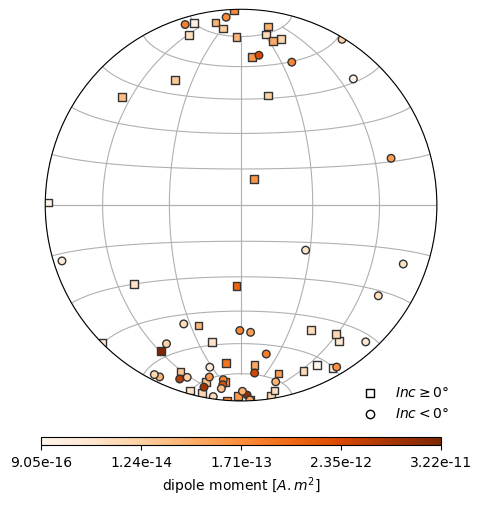

In [24]:
fig, ax = mplstereonet.subplots(1, 1, figsize=(4, 4), constrained_layout=True)
ax.grid()
estimated = mg.vector_to_angles(estimated_dipole_moments_itr_euler)
scatter_args = dict(
    vmin=np.log10(np.min(estimated[2])),
    vmax=np.log10(np.max(estimated[2])),
    cmap="Oranges",
    edgecolors="#333333",
    linewidths=1,
    s=30,
    zorder=2,
)
pos_inc = estimated[0] > 0
tmp = ax.scatter(
    *mplstereonet.line(estimated[0][pos_inc], estimated[1][pos_inc]),
    c=np.log10(estimated[2][pos_inc]),
    marker="s",
    **scatter_args,
)
tmp = ax.scatter(
    *mplstereonet.line(-estimated[0][~pos_inc], estimated[1][~pos_inc]),
    c=np.log10(estimated[2][~pos_inc]),
    marker="o",
    **scatter_args,
)

ticks=np.linspace( np.log10(np.min(estimated[2])),
                   np.log10(np.max(estimated[2])), 5)
tick_labels = []
for i in (ticks):
    tick_labels.append("{:.2e}".format(10**i))

    
clb = fig.colorbar(
    tmp, 
    cax=fig.add_axes([0, -0.1, 1, 0.02]), 
    orientation="horizontal", 
    label="dipole moment [$A.m^2$]",
    format="%.2e",
    ticks = ticks).set_ticklabels(tick_labels)

plt.scatter([],[], marker='s', color='white', edgecolors='k', label=r'$Inc \geq 0° $')
plt.scatter([],[], marker='o', color='white', edgecolors='k', label=r'$Inc < 0° $')

legend = plt.legend(bbox_to_anchor=(1.05, 9.0), frameon=1, framealpha=1.0)
frame = legend.get_frame()
frame.set_facecolor('w')
frame.set_edgecolor('w')

plt.show()

### Interfering sources method with $b_z$ vector

In [25]:
import numba
import choclo
import scipy
from micromag import TESLA_TO_NANOTESLA, MICROMETER_TO_METER

def all_dipole_moment_inversion(data, dipole_coordinates):
    
    data = data.to_xarray()
    
    n_data = len(data['bz']) #table.shape[0]
    n_params = len(dipole_coordinates[0])*3
    
    A = np.empty((n_data, n_params))
    
    d = np.array(data['bz']).ravel() / TESLA_TO_NANOTESLA #table.bz.values / TESLA_TO_NANOTESLA
    
    # Fill the Jacobian using a fast calculation with numba
    _dipole_jacobian_fast(
        data.x.values * MICROMETER_TO_METER,
        data.y.values * MICROMETER_TO_METER,
        data.z.values * MICROMETER_TO_METER,
        dipole_coordinates[0] * MICROMETER_TO_METER,
        dipole_coordinates[1] * MICROMETER_TO_METER,
        dipole_coordinates[2] * MICROMETER_TO_METER,
        A,
    )
    
    
    
    hessian = A.T @ A
    neg_gradient = A.T @ d
    dipole_moment = scipy.linalg.solve(hessian, neg_gradient, assume_a="pos")
    residuals = d - A @ dipole_moment
    
    dipole_moment = np.reshape(dipole_moment, (int(n_params/3), 3) )
    return dipole_moment 

@numba.jit(nopython=True, parallel=True)
def _dipole_jacobian_fast(e, n, u, de, dn, du, jacobian):
    """
    This is the bit that runs the fast for-loops
    """
    constant = choclo.constants.VACUUM_MAGNETIC_PERMEABILITY / (4 * np.pi)

    for j in numba.prange(len(de)):
        for i in numba.prange(len(e)):
            # Calculating the distance only once saves a lot of computation time
            distance = choclo.utils.distance_cartesian(
                e[i],
                n[i],
                u[i],
                de[j],
                dn[j],
                du[j],
            )
            # These are the second derivatives of 1/r
            jacobian[i, j*3] = constant * choclo.point.kernel_eu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance   =distance,
            )
            jacobian[i, j*3+1] = constant * choclo.point.kernel_nu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance=distance,
            )
            jacobian[i, j*3+2] = constant * choclo.point.kernel_uu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance   =distance,
            )
            


In [26]:
start_interf_bz_time = time.perf_counter()

estimated_dipole_moments_interf_bz = all_dipole_moment_inversion(df, positions_itr)
# print(estimated_dipole_moments_interf_bz)

end_interf_bz_time = time.perf_counter()

In [27]:
interf_bz_time = end_interf_bz_time-start_interf_bz_time
print(f"Time for the iterative Euler solution and interfering sources bz estimation: {round(itr_euler_time+interf_bz_time, 2)} seconds", )

Time for the iterative Euler solution and interfering sources bz estimation: 16.33 seconds


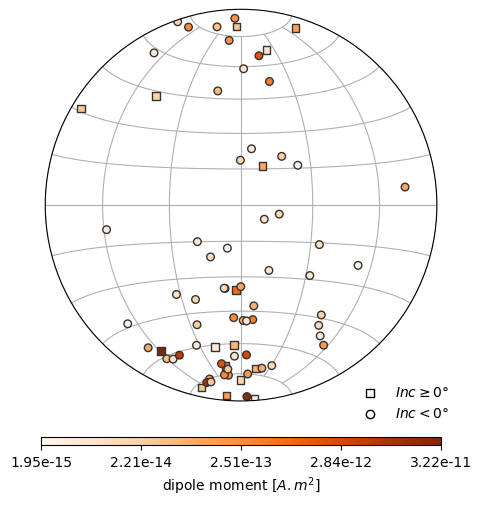

In [28]:
fig, ax = mplstereonet.subplots(1, 1, figsize=(4, 4), constrained_layout=True)
ax.grid()
estimated = mg.vector_to_angles(estimated_dipole_moments_interf_bz)
scatter_args = dict(
    vmin=np.log10(np.min(estimated[2])),
    vmax=np.log10(np.max(estimated[2])),
    cmap="Oranges",
    edgecolors="#333333",
    linewidths=1,
    s=30,
    zorder=2,
)
pos_inc = estimated[0] > 0
tmp = ax.scatter(
    *mplstereonet.line(estimated[0][pos_inc], estimated[1][pos_inc]),
    c=np.log10(estimated[2][pos_inc]),
    marker="s",
    **scatter_args,
)
tmp = ax.scatter(
    *mplstereonet.line(-estimated[0][~pos_inc], estimated[1][~pos_inc]),
    c=np.log10(estimated[2][~pos_inc]),
    marker="o",
    **scatter_args,
)

ticks=np.linspace( np.log10(np.min(estimated[2])),
                   np.log10(np.max(estimated[2])), 5)
tick_labels = []
for i in (ticks):
    tick_labels.append("{:.2e}".format(10**i))

    
clb = fig.colorbar(
    tmp, 
    cax=fig.add_axes([0, -0.1, 1, 0.02]), 
    orientation="horizontal", 
    label="dipole moment [$A.m^2$]",
    format="%.2e",
    ticks = ticks).set_ticklabels(tick_labels)

plt.scatter([],[], marker='s', color='white', edgecolors='k', label=r'$Inc \geq 0° $')
plt.scatter([],[], marker='o', color='white', edgecolors='k', label=r'$Inc < 0° $')

legend = plt.legend(bbox_to_anchor=(1.05, 9.0), frameon=1, framealpha=1.0)
frame = legend.get_frame()
frame.set_facecolor('w')
frame.set_edgecolor('w')

plt.show()

### Interfering sources method with $\frac{\partial b_z}{\partial z}$ vector

In [29]:
import numba
import choclo
import scipy
from micromag import TESLA_TO_NANOTESLA, MICROMETER_TO_METER


from numba import jit

@jit(nopython=True)
def kernel_uuu(
    easting_p, northing_p, upward_p, easting_q, northing_q, upward_q, distance
):
    r"""
    Second derivative of the inverse of the distance along upward-upward

    .. important ::

        The coordinates of the two points must be in Cartesian coordinates and
        have the same units.

    Parameters
    ----------
    easting_p : float
        Easting coordinate of point :math:`\mathbf{p}`.
    northing_p : float
        Northing coordinate of point :math:`\mathbf{p}`.
    upward_p : float
        Upward coordinate of point :math:`\mathbf{p}`.
    easting_q : float
        Easting coordinate of point :math:`\mathbf{q}`.
    northing_q : float
        Northing coordinate of point :math:`\mathbf{q}`.
    upward_q : float
        Upward coordinate of point :math:`\mathbf{q}`.
    distance : float
        Euclidean distance between points :math:`\mathbf{p}` and
        :math:`\mathbf{q}`.

    Returns
    -------
    kernel : float
        Value of the kernel function.


    """
    return 9 * (upward_p - upward_q) / distance**5 - 15 * (upward_p - upward_q)**3 / distance**7



@jit(nopython=True)
def kernel_euu(
    easting_p, northing_p, upward_p, easting_q, northing_q, upward_q, distance
):
    r"""
    Second derivative of the inverse of the distance along easting-upward

    .. important ::

        The coordinates of the two points must be in Cartesian coordinates and
        have the same units.

    Parameters
    ----------
    easting_p : float
        Easting coordinate of point :math:`\mathbf{p}`.
    northing_p : float
        Northing coordinate of point :math:`\mathbf{p}`.
    upward_p : float
        Upward coordinate of point :math:`\mathbf{p}`.
    easting_q : float
        Easting coordinate of point :math:`\mathbf{q}`.
    northing_q : float
        Northing coordinate of point :math:`\mathbf{q}`.
    upward_q : float
        Upward coordinate of point :math:`\mathbf{q}`.
    distance : float
        Euclidean distance between points :math:`\mathbf{p}` and
        :math:`\mathbf{q}`.

    Returns
    -------
    kernel : float
        Value of the kernel function.
    """
    return (  3 *  (easting_p - easting_q) / distance**5 
            - 15 * (easting_p - easting_q) * (upward_p - upward_q)**2 / distance**7)


@jit(nopython=True)
def kernel_nuu(
    easting_p, northing_p, upward_p, easting_q, northing_q, upward_q, distance
):
    r"""
    Second derivative of the inverse of the distance along easting-upward

    .. important ::

        The coordinates of the two points must be in Cartesian coordinates and
        have the same units.

    Parameters
    ----------
    easting_p : float
        Easting coordinate of point :math:`\mathbf{p}`.
    northing_p : float
        Northing coordinate of point :math:`\mathbf{p}`.
    upward_p : float
        Upward coordinate of point :math:`\mathbf{p}`.
    easting_q : float
        Easting coordinate of point :math:`\mathbf{q}`.
    northing_q : float
        Northing coordinate of point :math:`\mathbf{q}`.
    upward_q : float
        Upward coordinate of point :math:`\mathbf{q}`.
    distance : float
        Euclidean distance between points :math:`\mathbf{p}` and
        :math:`\mathbf{q}`.

    Returns
    -------
    kernel : float
        Value of the kernel function.
    """
    return (  3 *  (northing_p - northing_q) / distance**5 
            - 15 * (northing_p - northing_q) * (upward_p - upward_q)**2 / distance**7)


def z_deriv_all_dipole_moment_inversion(data, dipole_coordinates):
    
    data = data.to_xarray()
    
    n_data = len(data['z_deriv']) #table.shape[0]
    n_params = len(dipole_coordinates[0])*3
    
    A = np.empty((n_data, n_params))
    
    d = np.array(data['z_deriv']).ravel() #*-1.0e-3 # CONVERTING nT/microm to T/m
    
    # Fill the Jacobian using a fast calculation with numba
    _dipole_jacobian_fast(
        data.x.values * MICROMETER_TO_METER,
        data.y.values * MICROMETER_TO_METER,
        data.z.values * MICROMETER_TO_METER,
        dipole_coordinates[0] * MICROMETER_TO_METER,
        dipole_coordinates[1] * MICROMETER_TO_METER,
        dipole_coordinates[2] * MICROMETER_TO_METER,
        A,
    )
    
    
    
    hessian = A.T @ A
    neg_gradient = A.T @ d
    dipole_moment = scipy.linalg.solve(hessian, neg_gradient, assume_a="pos")
    residuals = d - A @ dipole_moment
    
    dipole_moment = np.reshape(dipole_moment, (int(n_params/3), 3) )
    return dipole_moment * 1.0e-3


@numba.jit(nopython=True, parallel=True)
def _dipole_jacobian_fast(e, n, u, de, dn, du, jacobian):
    """
    This is the bit that runs the fast for-loops
    """
    constant = choclo.constants.VACUUM_MAGNETIC_PERMEABILITY / (4 * np.pi)

    for j in numba.prange(len(de)):
        for i in numba.prange(len(e)):
            # Calculating the distance only once saves a lot of computation time
            distance = choclo.utils.distance_cartesian(
                e[i],
                n[i],
                u[i],
                de[j],
                dn[j],
                du[j],
            )
            # These are the second derivatives of 1/r
            jacobian[i, j*3] = constant*kernel_euu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance   =distance,
            )
            jacobian[i, j*3+1] = constant*kernel_nuu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance=distance,
            )
            jacobian[i, j*3+2] = constant*kernel_uuu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance   =distance,
            )
            

In [30]:
start_interf_z_deriv_time = time.perf_counter()

estimated_dipole_moments_interf_z_deriv = z_deriv_all_dipole_moment_inversion(df, positions_itr)
# print(estimated_dipole_moments_interf_bz)

end_interf_z_deriv_time = time.perf_counter()

In [31]:
interf_z_deriv_time = end_interf_z_deriv_time-start_interf_z_deriv_time
print(f"Time for the iterative Euler solution and interfering sources bz estimation: {round(itr_euler_time+interf_z_deriv_time, 2)} seconds", )

Time for the iterative Euler solution and interfering sources bz estimation: 16.28 seconds


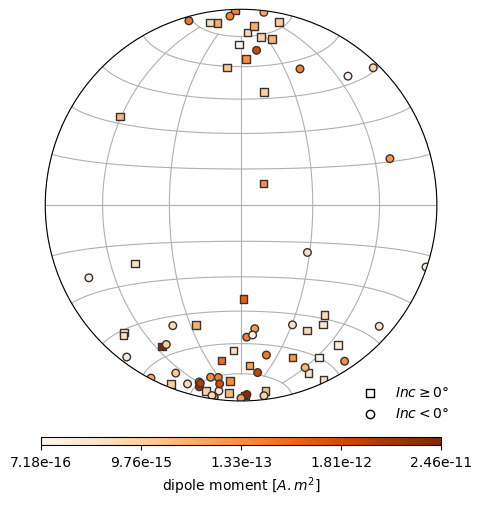

In [32]:
fig, ax = mplstereonet.subplots(1, 1, figsize=(4, 4), constrained_layout=True)
ax.grid()
estimated = mg.vector_to_angles(estimated_dipole_moments_interf_z_deriv)
scatter_args = dict(
    vmin=np.log10(np.min(estimated[2])),
    vmax=np.log10(np.max(estimated[2])),
    cmap="Oranges",
    edgecolors="#333333",
    linewidths=1,
    s=30,
    zorder=2,
)
pos_inc = estimated[0] > 0
tmp = ax.scatter(
    *mplstereonet.line(estimated[0][pos_inc], estimated[1][pos_inc]),
    c=np.log10(estimated[2][pos_inc]),
    marker="s",
    **scatter_args,
)
tmp = ax.scatter(
    *mplstereonet.line(-estimated[0][~pos_inc], estimated[1][~pos_inc]),
    c=np.log10(estimated[2][~pos_inc]),
    marker="o",
    **scatter_args,
)

ticks=np.linspace( np.log10(np.min(estimated[2])),
                   np.log10(np.max(estimated[2])), 5)
tick_labels = []
for i in (ticks):
    tick_labels.append("{:.2e}".format(10**i))

    
clb = fig.colorbar(
    tmp, 
    cax=fig.add_axes([0, -0.1, 1, 0.02]), 
    orientation="horizontal", 
    label="dipole moment [$A.m^2$]",
    format="%.2e",
    ticks = ticks).set_ticklabels(tick_labels)

plt.scatter([],[], marker='s', color='white', edgecolors='k', label=r'$Inc \geq 0° $')
plt.scatter([],[], marker='o', color='white', edgecolors='k', label=r'$Inc < 0° $')

legend = plt.legend(bbox_to_anchor=(1.05, 9.0), frameon=1, framealpha=1.0)
frame = legend.get_frame()
frame.set_facecolor('w')
frame.set_edgecolor('w')

plt.show()

# Final Comparison

In [33]:
fig_dir = pathlib.Path("..") / "paper" / "figures"
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}

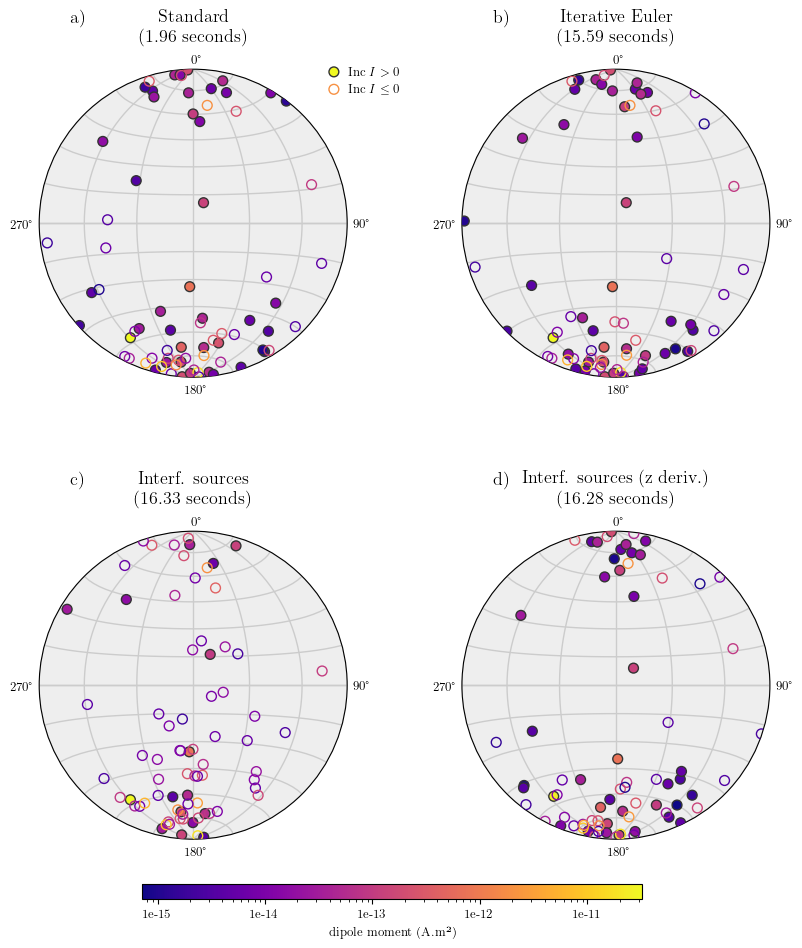

In [34]:
with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(10, 10))
    axes = []

#     estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
#     vmin = np.min(estimated)
#     vmax = np.max(estimated)
    
    estimated1 = mg.vector_to_angles(estimated_dipole_moments)[2]
    estimated2 = mg.vector_to_angles(estimated_dipole_moments_itr_euler)[2]
    estimated3 = mg.vector_to_angles(estimated_dipole_moments_interf_bz)[2]
    estimated4 = mg.vector_to_angles(estimated_dipole_moments_interf_z_deriv)[2]
    
    vmin = np.min([np.min(estimated1),np.min(estimated2),np.min(estimated3),np.min(estimated4)])
    vmax = np.max([np.max(estimated1),np.max(estimated2),np.max(estimated3),np.max(estimated4)])
    
    cmap = "plasma"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize

        
        
    ## STANDARD METHOD
    ax = fig.add_subplot(2, 2, 1, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs)
    ax.legend(loc=(0.9, 0.9), frameon=False, handletextpad=0.1, prop = {'size' : 9})
    fig.colorbar(
        tmp, 
        cax=fig.add_axes([0.25, 0.05, 0.5, 0.015]), 
        format="%.0g",
        label="dipole moment (A.m²)",
        orientation="horizontal",
    )

    
    
    
    ## ITERATIVE METHOD
    ax = fig.add_subplot(2, 2, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler, marker="o", zorder=1000, label="Inc", **kwargs)

    
    
    ## ITERATIVE METHOD W/ Bz DATA
    ax = fig.add_subplot(2, 2, 3, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments_interf_bz, marker="o", zorder=1000, label="Inc", **kwargs)

    
    
    
    ## ITERATIVE METHOD W/ Bz deriv DATA
    ax = fig.add_subplot(2, 2, 4, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments_interf_z_deriv, marker="o", zorder=1000, label="Inc", **kwargs)

    
           
    
    
    
    
    titles = ([r'Standard'+'\n'+ f'({round(inversion_time, 2)} seconds)', 
           'Iterative Euler'+'\n'+ f'({round(itr_euler_time, 2)} seconds)', 
           'Interf. sources'+'\n'+ f'({round(itr_euler_time+interf_bz_time, 2)} seconds)', 
           'Interf. sources (z deriv.)'+'\n'+ f'({round(itr_euler_time+interf_z_deriv_time, 2)} seconds)'])

    for ax, letter, title in zip(axes, "a b c d".split(), titles):
        ax.text(0.1, 1.15, f"{letter})   ", transform=ax.transAxes, fontsize=13)
        ax.set_title(title+'\n', fontsize=13, loc='center')
    fig.subplots_adjust(wspace=0.2, hspace=0.5)

    plt.show()

# R-squared score filter

In [35]:
def calculated_r2_interf_sources_bz(data, coordinates, dipole_coordinates, dipole_moments, 
                                 windows, height_difference):
    calculated_r2_interf = []
    
    # Calculate predicted model
    predicted_model = mg.dipole_bz(coordinates, dipole_coordinates, dipole_moments)
    
    # Calculate predicted model 
    predicted = vd.make_xarray_grid(coordinates, predicted_model, data_names=["bz"], 
                                    dims=("y", "x"), extra_coords_names="z")
    predicted.x.attrs = {"units": "µm"}
    predicted.y.attrs = {"units": "µm"}
    predicted.bz.attrs = {"long_name": "vertical magnetic field", "units": "nT"}

    # Upward continuation of the predicted model 
    pred_up = (
                hm.upward_continuation(predicted.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data.x, y=data.y)
                .assign_coords(z=data.z + height_difference)
               )
    # Upward continuation of data
    
    data_up = (
                hm.upward_continuation(data.bz, height_difference)
                .assign_attrs(data.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data.x, y=data.y)
                .assign_coords(z=data.z + height_difference)
               )
    
    # Calculate r2 of each window
    for window in windows:
        data_up_slice = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
        pred_up_slice = pred_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
        
        residuals = data_up_slice.bz.values - pred_up_slice.bz.values
        residuals_sum_sq = np.sum(residuals**2)
        
        # R² Coeficient of Determination (dimensionless)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_up_slice.bz.values - np.mean(data_up_slice.bz.values)) ** 2
        
        calculated_r2_interf.append(r2)
    
    return np.array(calculated_r2_interf)



def calculated_r2_interf_sources_bzz(data, coordinates, dipole_coordinates, dipole_moments, 
                                 windows, height_difference):
    calculated_r2_interf = []
    
    # Calculate predicted model
    predicted_model = mg.dipole_bz(coordinates, dipole_coordinates, dipole_moments)
    
    # Calculate predicted model 
    predicted = vd.make_xarray_grid(coordinates, predicted_model, data_names=["bz"], 
                                    dims=("y", "x"), extra_coords_names="z")
    predicted.x.attrs = {"units": "µm"}
    predicted.y.attrs = {"units": "µm"}
    predicted.bz.attrs = {"long_name": "vertical magnetic field", "units": "nT"}
    
    # Upward continuation of the predicted model 
    pred_up = (
                hm.upward_continuation(predicted.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data.x, y=data.y)
                .assign_coords(z=data.z + height_difference)
               )
    # Upward continuation of data
    
#     # remove median
#     median = np.median(data.bz.values)
#     data.bz.values -= median
    
    data_up = (
                hm.upward_continuation(data.bz, height_difference)
                .assign_attrs(data.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data.x, y=data.y)
                .assign_coords(z=data.z + height_difference)
               )
    
    data_up = data_up.assign(mg.data_gradients(data_up.bz))
    pred_up = data_up.assign(mg.data_gradients(pred_up.bz))
    
    # Calculate r2 of each window
    for window in windows:
        data_up_slice = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
        pred_up_slice = pred_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
        
        residuals = data_up_slice.z_deriv.values - pred_up_slice.z_deriv.values
        residuals_sum_sq = np.sum(residuals**2)
        
        # R² Coeficient of Determination (dimensionless)
        r2 = 1 - residuals_sum_sq / np.linalg.norm(data_up_slice.z_deriv.values - np.mean(data_up_slice.z_deriv.values)) ** 2
        
        calculated_r2_interf.append(r2)
    
    return np.array(calculated_r2_interf)

In [36]:
import warnings
warnings.filterwarnings('ignore')

calculated_r2_interf_bz = calculated_r2_interf_sources_bz(data, coordinates, positions_itr, 
                                                    estimated_dipole_moments_interf_bz, 
                                                    np.array(windows_filtered), height_difference)

calculated_r2_interf_z_deriv = calculated_r2_interf_sources_bzz(data, coordinates, positions_itr, 
                                                    estimated_dipole_moments_interf_z_deriv, 
                                                    np.array(windows_filtered), height_difference)


In [44]:
print(np.array(calculated_r2)[np.array(calculated_r2)>=0.85])
print()
print(calculated_r2_itr_euler[calculated_r2_itr_euler>=0.85])
print()
print(calculated_r2_interf_bz[calculated_r2_interf_bz>=0.85])
print()
print(calculated_r2_interf_z_deriv[calculated_r2_interf_z_deriv>=0.85])

[0.88785769 0.91735136 0.9946005  0.972851   0.9972637  0.98168351
 0.98489374 0.99917826 0.99607567 0.96030063 0.9991423  0.99705428
 0.95152628 0.93842917 0.99490758 0.97903222 0.96794878 0.96675444
 0.94388367 0.98335229 0.96391143 0.97033934 0.96127153 0.95532205
 0.99606017 0.93531699 0.9170259  0.90111836 0.95671122 0.92863515
 0.99063131 0.97041723 0.99235214 0.8627354  0.94280392 0.87299364
 0.86993956 0.8940612  0.85441422 0.94166055 0.96703895 0.9193462
 0.98072462 0.90783064 0.90438294 0.92110664]

[0.88785769 0.91735074 0.9946009  0.97284885 0.99729298 0.98167138
 0.99745987 0.99916336 0.99606539 0.96353631 0.99916048 0.99705727
 0.95240467 0.93881418 0.99188641 0.97907782 0.96801427 0.96678045
 0.94496116 0.98335899 0.96390818 0.97032462 0.9828712  0.95798308
 0.99648601 0.93177276 0.91756605 0.91457213 0.95315024 0.92848335
 0.98575408 0.96503399 0.9949     0.86363785 0.93064461 0.96634489
 0.89505472 0.8790025  0.94908138 0.85429862 0.90843993 0.96620661
 0.93210485 0.97

# Paper's figures 

In [38]:
fig_dir = pathlib.Path("..") / "paper" / "figures"
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}

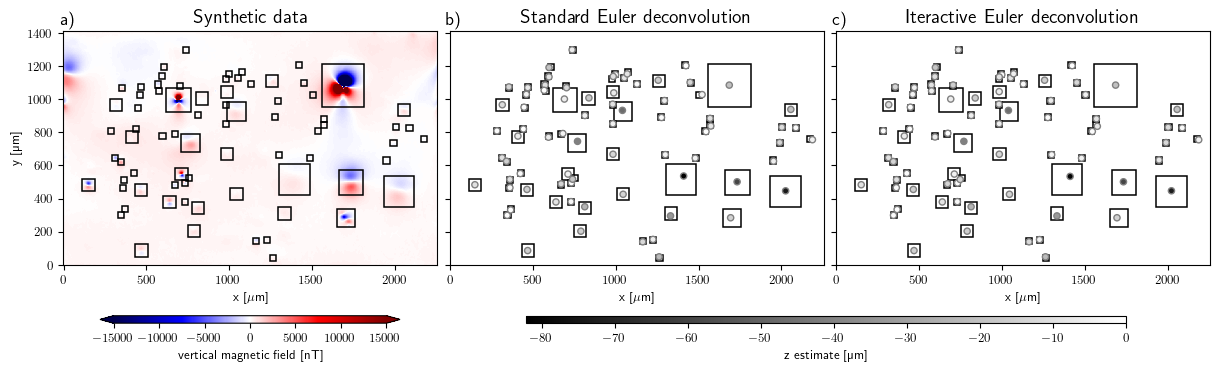

In [39]:
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True, sharex=True)
    cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.0, shrink=0.5)

    # data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
    axes = axes.ravel()

    ax = axes[0]


    tmp1 = data_up['bz'].plot.pcolormesh(ax=ax, cmap='seismic', vmin=-15000, vmax=15000, add_colorbar=False)#, cbar_kwargs=cbar_kwargs)
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)


    scale = vd.maxabs((positions[2], positions_itr[2]))

    ax = axes[1]
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)

    tmp = ax.scatter(*positions[:2], c=positions[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    ax = axes[2]
    for window in windows_filtered:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1.1,
        )
        ax.add_patch(rect)

    tmp = ax.scatter(*positions_itr[:2], c=positions_itr[2], s=20, cmap="gray", vmin=-scale, vmax=0, edgecolor='gray')

    titles = ([r'Synthetic data',
               r'Standard Euler deconvolution', 
               r'Iteractive Euler deconvolution'])
    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(-0.01, 1.025, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")
        ax.set_title(title, fontsize=14)
        ax.set_xlabel(r"x [$\mu$m]")

    plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)


    fig.colorbar(tmp1, **cbar_kwargs, extend='both', label="vertical magnetic field [nT]", cax=fig.add_axes([0.075, 0.15, 0.25, 0.015]))
    fig.colorbar(tmp, **cbar_kwargs, label="z estimate [µm]", cax=fig.add_axes([0.43, 0.15, 0.5, 0.015]))
    fig.savefig(fig_dir / "euler-comparion-real.png", dpi=300, facecolor='w', bbox_inches='tight')
    
plt.show()
